# Data Loading & Wrangling

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, lit
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC

In [3]:
# Create Spark Session
spark = SparkSession \
    .builder \
    .appName("DataFrames Practice") \
    .getOrCreate()

df = spark.read.json('../data/medium-sparkify-event-data.json')

In [4]:
# Shape of raw data (rows, columns)
print(df.count(), len(df.columns))

543705 18


In [5]:
# Users not signed up yet
df.filter(df['userId']=='').count()

15700

In [6]:
# Clean Data : Those users not signed up yet are excluded
df = df.filter(df['userId']!='')

In [5]:
# Filter Churned users and separate them from current users
churn_record = df.filter((df['page']=='Cancellation Confirmation') | (df['page']=='Submit Downgrade')) \
                    .dropDuplicates(['userId'])

churn_users = churn_record.select('userId') \
                .rdd.flatMap(lambda x: x) \
                .collect()

df_churn = df.filter(df['userId'].isin(churn_users))
df_not_churn = df.filter(~df['userId'].isin(churn_users))

# Create Churn Column and represent 1 if a user is a churned user
df_churn = df_churn.withColumn("churn", lit(1))
df_not_churn = df_not_churn.withColumn("churn", lit(0))

In [6]:
# Filter users who have cancellation log
cancel_record = df.filter(df['page']=='Cancellation Confirmation')

canceled_users = cancel_record.select('userId') \
                    .rdd.flatMap(lambda x: x) \
                    .collect()

df_cancel = df.filter(df['userId'].isin(canceled_users))

In [7]:
# Filter users who have experience in premium service
paid_users = df.filter(df['level']=='paid') \
                .select('userId') \
                .rdd.flatMap(lambda x: x) \
                .collect()

df_paid = df.filter(df['userId'].isin(paid_users))

# Data Exploration & Visualization

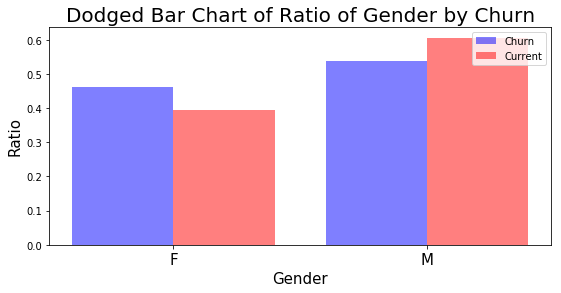

In [8]:
# Gender Ratio
churn_gender_pd = df_churn.groupBy('gender').count().toPandas()
not_churn_gender_pd = df_not_churn.groupBy('gender').count().toPandas()

not_churn_gender_pd['ratio'] = not_churn_gender_pd['count'] / not_churn_gender_pd['count'].sum()
churn_gender_pd['ratio'] = churn_gender_pd['count'] / churn_gender_pd['count'].sum()

label = churn_gender_pd['gender'].tolist()
index = np.arange(len(label))
bar_width = 0.4

plt.figure(figsize=(9, 4))

p1 = plt.bar(index, churn_gender_pd['ratio'],
             width = bar_width,
             color = 'blue',
             alpha = 0.5)

p2 = plt.bar(index + bar_width, not_churn_gender_pd['ratio'],
             width = bar_width,
             color = 'red',
             alpha = 0.5)

plt.title('Dodged Bar Chart of Ratio of Gender by Churn', fontsize=20)
plt.ylabel('Ratio', fontsize=15)
plt.xlabel('Gender', fontsize=15)
plt.xticks(index + bar_width/2, label, fontsize=15)
plt.legend((p1[0], p2[0]), ('Churn', 'Current'), loc='upper right', fontsize=10)

plt.show()

print(churn_gender_pd['count'] / churn_gender_pd['count'].sum())
print(not_churn_gender_pd['count'] / not_churn_gender_pd['count'].sum()) 

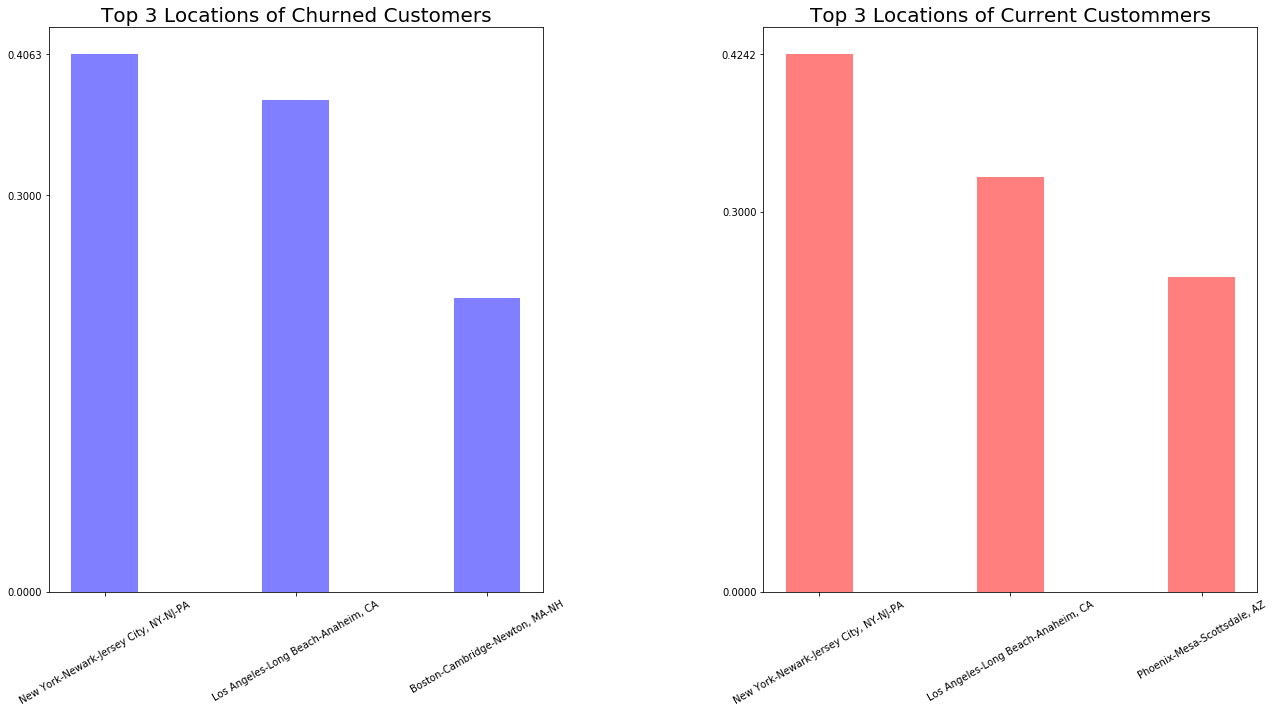

In [9]:
# Location Ratio
churn_loc_pd = df_churn.groupBy('location').count().toPandas()
not_churn_loc_pd = df_not_churn.groupBy('location').count().toPandas()

top3_loc_churn = churn_loc_pd.sort_values('count', ascending=False).head(3)
top3_loc_not_churn = not_churn_loc_pd.sort_values('count', ascending=False).head(3)

top3_loc_churn['ratio'] = top3_loc_churn['count'] / top3_loc_churn['count'].sum()
top3_loc_not_churn['ratio'] = top3_loc_not_churn['count'] / top3_loc_not_churn['count'].sum()

label_churn = top3_loc_churn['location'].tolist()
label_not_churn = top3_loc_not_churn['location'].tolist()

index_churn = np.arange(len(label_churn))
index_not_churn = np.arange(len(label_not_churn))

fig = plt.figure(figsize=(20, 10))

fig.subplots_adjust(wspace=4)

p1 = fig.add_subplot(1, 2, 1)
p2 = fig.add_subplot(1, 2, 2)

p1.bar(index_churn, top3_loc_churn['ratio'],
       width = 0.35,
       color = 'blue',
       alpha = 0.5)
p1.set_title("Top 3 Locations of Churned Customers", fontsize=20)
plt.setp(p1, xticks=index_churn, xticklabels=label_churn, yticks=[0, 0.3, max(top3_loc_churn['ratio'])])
p1.set_xticklabels(label_churn, rotation=30)

p2.bar(index_not_churn, top3_loc_not_churn['ratio'],
       width = 0.35,
       color = 'red',
       alpha = 0.5)
p2.set_title("Top 3 Locations of Current Custommers", fontsize=20)
plt.setp(p2, xticks=index_not_churn, xticklabels=label_not_churn, yticks=[0, 0.3, max(top3_loc_not_churn['ratio'])])
p2.set_xticklabels(label_not_churn, rotation=30)

plt.tight_layout()
plt.show()

print(top3_loc_churn['count'] / top3_loc_churn['count'].sum())
print(top3_loc_not_churn['count'] / top3_loc_not_churn['count'].sum())

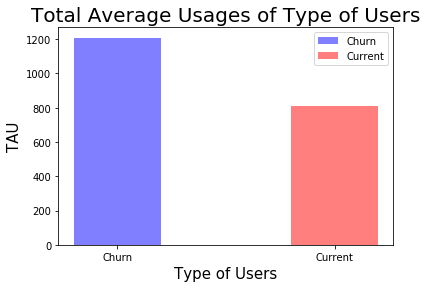

In [10]:
# User Behavior - Usage of Sparkify
churn_usage = df_churn.filter(df_churn.page == 'NextSong') \
                .select('userId') \
                .groupBy('userId') \
                .agg({'userId':'count'}) \
                .withColumnRenamed('count(userId)', 'usage_count') \
                .sort(desc('usage_count')) \
                .toPandas()

not_churn_usage = df_not_churn.filter(df_not_churn.page == 'NextSong') \
                    .select('userId') \
                    .groupBy('userId') \
                    .agg({'userId':'count'}) \
                    .withColumnRenamed('count(userId)', 'usage_count') \
                    .sort(desc('usage_count')) \
                    .toPandas()

churn_TAU = churn_usage.usage_count.sum() / churn_usage.userId.count()
current_TAU = not_churn_usage.usage_count.sum() / not_churn_usage.userId.count()
label = ['Churn', 'Current']
bar_width =0.4

plt.figure(figsize=(6, 4))
plot = plt.bar(label, [churn_TAU, current_TAU],
               color=['blue', 'red'],
               alpha=0.5,
               width=bar_width)

plt.title('Total Average Usages of Type of Users', fontsize=20)
plt.ylabel('TAU', fontsize=15)
plt.xlabel('Type of Users', fontsize = 15)
plt.legend((plot[0], plot[1]), ('Churn', 'Current'), loc='upper right', fontsize=10)

plt.show()

print(churn_usage.usage_count.sum() / churn_usage.userId.count())
print(not_churn_usage.usage_count.sum() / not_churn_usage.userId.count())

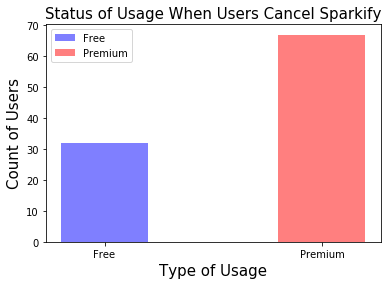

In [129]:
# Status of usage when users cancel Sparkify service
fr_cancel_num = df_cancel.filter((df_cancel['page']=="Cancellation Confirmation") & (df_cancel['level']=="free")) \
                .select('userId') \
                .count()
pr_cancel_num = df_cancel.filter((df_cancel['page']=="Cancellation Confirmation") & (df_cancel['level']=="paid")) \
                .select('userId') \
                .count()

label = ['Free', 'Premium']
bar_width = 0.4

plt.figure(figsize=(6, 4))

plot = plt.bar(label, [fr_cancel_num, pr_cancel_num],
               color=['blue', 'red'],
               alpha=0.5,
               width=bar_width)

plt.title('Status of Usage When Users Cancel Sparkify', fontsize=15)
plt.ylabel('Count of Users', fontsize=15)
plt.xlabel('Type of Usage', fontsize = 15)
plt.legend((plot[0], plot[1]), ('Free', 'Premium'), loc='upper left', fontsize=10)

plt.show()

print(fr_cancel_num, pr_cancel_num)

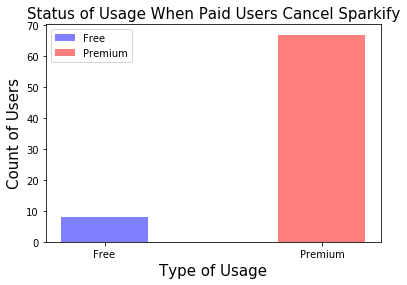

In [132]:
# Status of usage when paid users cancel Sparkify service
fr_cancel_num2 = df_paid.filter((df_paid['page']=="Cancellation Confirmation") & (df_paid['level']=="free")) \
                .select('userId') \
                .count()
pr_cancel_num2 = df_paid.filter((df_paid['page']=="Cancellation Confirmation") & (df_paid['level']=="paid")) \
                .select('userId') \
                .count()

label = ['Free', 'Premium']
bar_width = 0.4

plt.figure(figsize=(6, 4))

plot = plt.bar(label, [fr_cancel_num2, pr_cancel_num2],
               color=['blue', 'red'],
               alpha=0.5,
               width=bar_width)

plt.title('Status of Usage When Paid Users Cancel Sparkify', fontsize=15)
plt.ylabel('Count of Users', fontsize=15)
plt.xlabel('Type of Usage', fontsize = 15)
plt.legend((plot[0], plot[1]), ('Free', 'Premium'), loc='upper left', fontsize=10)

plt.show()

print(fr_cancel_num2, pr_cancel_num2)

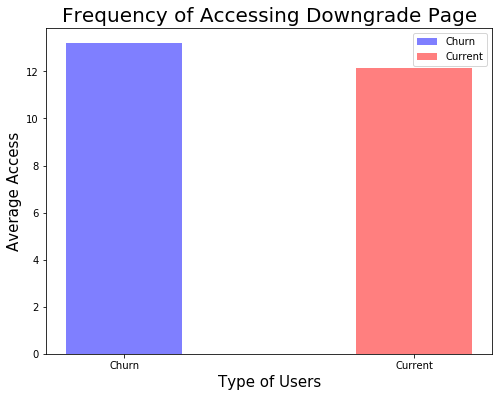

In [13]:
# The frequency of accessing Downgrade page
d_page_access_churn = df_churn.filter(df_churn['page']=='Downgrade') \
                        .select('userId') \
                        .groupBy('userId') \
                        .agg({'userId':'count'}) \
                        .withColumnRenamed('count(userId)', 'downgrade page access') \
                        .toPandas()
    
d_page_access_current = df_not_churn.filter(df_churn['page']=='Downgrade') \
                        .select('userId') \
                        .groupBy('userId') \
                        .agg({'userId':'count'}) \
                        .withColumnRenamed('count(userId)', 'downgrade page access') \
                        .toPandas()

d_frequency_churn = d_page_access_churn['downgrade page access'].sum() / d_page_access_churn.shape[0]
d_frequency_current = d_page_access_current['downgrade page access'].sum() / d_page_access_current.shape[0]

label = ['Churn', 'Current']
bar_width = 0.4

plt.figure(figsize=(8, 6))

plot = plt.bar(label, [d_frequency_churn, d_frequency_current],
               color=['blue', 'red'],
               alpha=0.5,
               width=bar_width)

plt.title('Frequency of Accessing Downgrade Page', fontsize=20)
plt.ylabel('Average Access', fontsize=15)
plt.xlabel('Type of Users', fontsize = 15)
plt.legend((plot[0], plot[1]), ('Churn', 'Current'), loc='upper right', fontsize=10)

plt.show()

print(d_frequency_churn, d_frequency_current)

# Feature Engineering

In [14]:
# Union two dataframes into a single dataframe
df = df_churn.union(df_not_churn).select('userId', 'gender', 'level', 'page', 'churn')

# Pivot level column and aggregate values for each users
df_level_cnt = df.groupby('userId', 'level') \
                 .pivot('level', ['free', 'paid']) \
                 .count() \
                 .drop('level') \
                 .orderBy('userId')

# Pivot page column and aggregate values for each users
df_page_cnt = df.filter((df['page']=='NextSong') | (df['page']=='Submit Downgrade') | (df['page']=='Submit Upgrade') | 
                        (df['page']=='Downgrade') | (df['page']=='Thumbs Up') | (df['page']=='Thumbs Down') | 
                        (df['page']=='Add to Playlist') | (df['page']=='Add Friend')) \
                .groupby('userId', 'page') \
                .pivot('page') \
                .count() \
                .drop('page') \
                .orderBy('userId')

# Drop the original level & page column and join above two dataframes with the original dataframe
df = df.drop('level', 'page') \
       .join(df_level_cnt, 'userId', 'inner') \
       .join(df_page_cnt, 'userId', 'inner') \
       .orderBy('userId') \
       .dropDuplicates()

# Aggregate users data to a single row represents a user information only
df = df.groupby('userId', 'gender').max()
features = df.select(['gender', 'max(free)', 'max(paid)', 'max(Add Friend)',
                      'max(Add to Playlist)', 'max(Downgrade)', 'max(NextSong)',
                      'max(Submit Downgrade)', 'max(Submit Upgrade)', 'max(Thumbs Down)', 
                      'max(Thumbs Up)', 'max(churn)']) \
             .withColumnRenamed('max(free)', 'free') \
             .withColumnRenamed('max(paid)', 'paid') \
             .withColumnRenamed('max(Add Friend)', 'add_friend') \
             .withColumnRenamed('max(Add to Playlist)', 'add_playlist') \
             .withColumnRenamed('max(Downgrade)', 'd_pge_access') \
             .withColumnRenamed('max(NextSong)', 'num_music') \
             .withColumnRenamed('max(Submit Downgrade)', 'num_downgrade') \
             .withColumnRenamed('max(Submit Upgrade)', 'num_upgrade') \
             .withColumnRenamed('max(Thumbs Down)', 'dislike') \
             .withColumnRenamed('max(Thumbs Up)', 'like') \
             .withColumnRenamed('max(churn)', 'churn') \
             .fillna(0)

In [15]:
features.persist()

DataFrame[gender: string, free: bigint, paid: bigint, add_friend: bigint, add_playlist: bigint, d_pge_access: bigint, num_music: bigint, num_downgrade: bigint, num_upgrade: bigint, dislike: bigint, like: bigint, churn: int]

In [16]:
# Feautres outlook
features.show()

+------+----+----+----------+------------+------------+---------+-------------+-----------+-------+----+-----+
|gender|free|paid|add_friend|add_playlist|d_pge_access|num_music|num_downgrade|num_upgrade|dislike|like|churn|
+------+----+----+----------+------------+------------+---------+-------------+-----------+-------+----+-----+
|     M|   0| 423|         3|          14|           1|      360|            0|          0|      1|  17|    1|
|     M|  60|3939|        71|          94|          40|     3382|            0|          1|     37| 143|    0|
|     F| 134|   0|         1|           3|           0|       96|            0|          0|      1|   5|    1|
|     F|  43| 134|         0|           3|           2|      137|            1|          1|      2|   8|    1|
|     F| 313| 514|         8|          19|          13|      661|            0|          1|     10|  16|    1|
|     F| 373|   0|         7|           7|           0|      262|            0|          0|      2|  15|    1|
|

In [18]:
# Shape of features & the number of churn and current users
print(features.count(), len(features.columns))
print(features.filter(features['churn']==1).count(), features.filter(features['churn']==0).count())

448 12
175 273


# Modeling

In [38]:
# PCA Analysis
indexer = StringIndexer(inputCol="gender", outputCol="gender_index")

assembler = VectorAssembler(inputCols=['gender_index', 'free', 'paid', 'add_friend', 'add_playlist', 'd_pge_access', 
                                       'num_music', 'num_downgrade', 'num_upgrade', 'dislike', 'like'], 
                            outputCol="features")

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

scaled_pipeline = Pipeline(stages=[indexer, assembler, scaler])
scaled_model = scaled_pipeline.fit(features)
scaled_result = scaled_model.transform(features)

pca = PCA(k=11, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_result)
pca_model.explainedVariance

DenseVector([0.4992, 0.3206, 0.1067, 0.0276, 0.0252, 0.0095, 0.007, 0.0027, 0.001, 0.0005, 0.0])

In [39]:
# Split dataset into train, and test split sets
rest, validation = features.randomSplit([0.75, 0.25], seed=42)

In [41]:
# String indexer for gender column
indexer = StringIndexer(inputCol="gender", outputCol="gender_index")

# Vector assembler for creating features
assembler = VectorAssembler(inputCols=['gender_index', 'free', 'paid', 'add_friend', 'add_playlist', 'd_pge_access', 
                                       'num_music', 'num_downgrade', 'num_upgrade', 'dislike', 'like'], 
                            outputCol="features")

# MinMax scaler for scaling features
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Principal Component Analysis for dimension reduction
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")

# Logistic regression model for baseline estimator
lr =  LogisticRegression(featuresCol='pcaFeatures', labelCol='churn', maxIter=10)

# Baseline modeling & Hyper parameter tuning
base_pipeline = Pipeline(stages=[indexer, assembler, scaler, pca, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.3, 0.5, 0.7, 0.9]) \
    .addGrid(lr.elasticNetParam, [0, 0.2, 0.5, 0.8, 1]) \
    .build()

crossval = CrossValidator(estimator=base_pipeline, 
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn'),
                          numFolds=10, 
                          parallelism=4)

base_model = crossval.fit(rest)

results = base_model.transform(validation)

# Multiclass Classification Evaluator to evaluate models' F1 score
evaluator = MulticlassClassificationEvaluator(labelCol='churn')

# Results of baseline model's F1 score, and its best hyperparameter
print('F1 score: {}'.format(evaluator.evaluate(results.select(['prediction', 'churn']))))
print('Best parameter for regParam: {}'.format(base_model.bestModel.stages[-1]._java_obj.parent().getRegParam()))
print('Best parameter for elasticNetParam: {}'.format(base_model.bestModel.stages[-1]._java_obj.parent().getElasticNetParam()))

# Above the evaluation code is referenced from:
# https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark

F1 score: 0.7836206896551724
Best parameter for regParam: 0.0
Best parameter for elasticNetParam: 0.0


In [101]:
# Gradient Boosted Tree for second estimator
gbt = GBTClassifier(featuresCol="scaledFeatures", labelCol="churn", maxIter=10)
gbt_pipeline = Pipeline(stages=[indexer, assembler, scaler, gbt])

gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt_pipeline,
                              estimatorParamMaps=gbt_paramGrid,
                              evaluator=MulticlassClassificationEvaluator(labelCol='churn'),
                              numFolds=10,
                              parallelism=4)

gbt_model = crossval_gbt.fit(rest)

results_gbt = gbt_model.transform(validation)

# Results of GBT model's F1 score
print('F1 score: {}'.format(evaluator.evaluate(results_gbt.select(['prediction', 'churn']))))
print('Best parameter for maxDepth: {}'.format(gbt_model.bestModel.stages[-1]._java_obj.parent().getMaxDepth()))

F1 score: 0.7836206896551724
Best parameter for maxDepth: 5


In [110]:
# Naive Bayes model for the third estimator
nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='churn', modelType='multinomial')
nb_pipeline = Pipeline(stages=[indexer, assembler, scaler, nb])

nb_paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0, 0.5, 1]) \
    .build()

crossval_nb = CrossValidator(estimator=nb_pipeline,
                             estimatorParamMaps=nb_paramGrid,
                             evaluator=MulticlassClassificationEvaluator(labelCol='churn'),
                             numFolds=10,
                             parallelism=4)

nb_model = crossval_nb.fit(rest)

results_nb = nb_model.transform(validation)

# Results of Naive Bayes model's F1 score, and its best hyperparameter
print('F1 score: {}'.format(evaluator.evaluate(results_nb.select(['prediction', 'churn']))))
print('Best parameter for Smoothing: {}'.format(nb_model.bestModel.stages[-1]._java_obj.parent().getSmoothing()))

F1 score: 0.8109092775041051
Best parameter for Smoothing: 0.0


In [114]:
# Linear SVC model for the final estimator
svm = LinearSVC(featuresCol='scaledFeatures', labelCol='churn', maxIter=10)
svm_pipeline = Pipeline(stages=[indexer, assembler, scaler, pca, svm])

svm_paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.05]) \
    .addGrid(svm.tol, [0.000001, 0.00001, 0.0001]) \
    .build()

crossval_svm = CrossValidator(estimator=svm_pipeline,
                             estimatorParamMaps=svm_paramGrid,
                             evaluator=MulticlassClassificationEvaluator(labelCol='churn'),
                             numFolds=10,
                             parallelism=4)

svm_model = crossval_svm.fit(rest)

results_svm = svm_model.transform(validation)

# Results of Naive Bayes model's F1 score, and its best hyperparameter
print('F1 score: {}'.format(evaluator.evaluate(results_svm.select(['prediction', 'churn']))))
print('Best parameter for regParam: {}'.format(svm_model.bestModel.stages[-1]._java_obj.parent().getRegParam()))
print('Best parameter for tol: {}'.format(svm_model.bestModel.stages[-1]._java_obj.parent().getTol()))

F1 score: 0.8109092775041051
Best parameter for regParam: 0.01
Best parameter for tol: 1e-06
